# File benchmark

In Data Analysis, sometimes it is relevant to use either file stores or S3 type storage services. This Input/Output operations involve reading and writing files. Oftentimes, file sizes are quite large -- hence knowing the types of file formats to use is important, as it could save you quite a lot of time in terms of save or load time. With storage, the size of the file is also important as storage could be expensive. 

This workbook does a benchmark assessment of a few well known file types. It is quite similar to other benchmark studies, such as [this 'towards data science' format study by Ilia Zaitsev in 2017](https://towardsdatascience.com/the-best-format-to-save-pandas-data-414dca023e0d).

## File formats analyzed

Old school file formats:
1. Pain CSV
2. Excel (xlsx)

Apache Arrow formats:
3. Parquet
4. Feather

Python specific formats:
5. Pickle
6. Compressed pickle (using zip format)

Other data formats:
7. HDF5

## Variables used in the analysis
* time to save a file (output to stored memory);
* time to load a file (input from stored memory);
* space on disk

## Dataset utilized in analyis

To analyze each file format, the relatively large dataset from [Dominiks' Fine foods](https://www.chicagobooth.edu/research/kilts/datasets/dominicks) scanner dataset was utilized as it contains a range of variables - numeric, string, and integer -- as well as being large (7.3M rows). 

## Note

As a side comment, while this analysis was done on Python, the conclusions are mostly applicable to R or other langauges exclusing the use of Pickle and compressed pickle formats, which are python formats.  

In [2]:
# %matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os

Setup a simple timer to return time taken for a task

In [3]:
import datetime

class Timer:
    """
    Simple timer. When first initiated, it starts, has one method stop(), it prints the time taken
    
    `
    t = Timer()
    t.stop()
    `
    
    By default, the Timer() will just print the length of time taken, however if you specify
    The stop(return_time=True), it will instead return a datetime object of time taken 
    """
    def __init__(self):
        # when first initiated, start the clock
        self.t_start = datetime.datetime.now()
        
    def stop(self, return_time=False):
        # end timer
        self.t_end = datetime.datetime.now()
        # return or print the length of time taken
        if return_time == True:
            return self.t_end - self.t_start
        else:
            print("Task took {t}".format(t=self.t_end - self.t_start))

Load the dataset used in the demo and see how long it is

**NOTE**: at this step, any `.csv` demo dataset can be substituted

In [4]:
demo_dataset = "https://www.chicagobooth.edu/-/media/enterprise/centers/kilts/datasets/dominicks-dataset/movement_csv-files/wana_csv.zip"

df = pd.read_csv(demo_dataset)
len(df)

7339217

Considering that there are 7.3M rows of data, this invalidates `xlsx` as the simple (or full) output type as this can only handle 1 million rows. If we had still wanted to work with excel for such a large dataset, we would have to split it into several 1M row files. Hence to simulate excel, we will just focus on saving or reading one 1M row file. To equalize the analysis at the end of the day, we will simply multiply the time taken to load/save/store 1m rows by 7.3

In [5]:
excel_muliplier = len(df)/1000000

## Setup Process to automate the tests

In [6]:
def execute_command(message, command):
    print("starting test:",message)
    total = None
    for each in range(0,4):
        t = Timer()
        exec(command)
        if total == None:
            total = t.stop(return_time=True)
        else:
            total = total + t.stop(return_time=True)
    print("took {l}".format(l=total/5))
    time_av = total/5
    # since excel can only store 1M records, multiply the excel estimate by the datasize ratio
    if message[:4] == "xlsx":
        time_av = time_av * excel_muliplier
    return message, time_av.total_seconds()

In [7]:
formats = {
    "pickle - write":"df.to_pickle('{}'.format(file_paths['pickle']))",
    "pickle - read":"df = pd.read_pickle('{}'.format(file_paths['pickle']))",
    "compressed pickle - write":"df.to_pickle('{}'.format(file_paths['compressed pickle']), compression='zip')",
    "compressed pickle - read":"df = pd.read_pickle('{}'.format(file_paths['compressed pickle']))",
    "csv - write":"df.to_csv('{}'.format(file_paths['csv']))",
    "csv - read":"df = pd.read_csv('{}'.format(file_paths['csv']))",
    "parquet - write":"df.to_parquet('{}'.format(file_paths['parquet']))",
    "parquet - read":"df = pd.read_parquet('{}'.format(file_paths['parquet']))",
    "feather - write":"df.to_feather('{}'.format(file_paths['feather']))",
    "feather - read":"df = pd.read_feather('{}'.format(file_paths['feather']))",
    "hdf5 - write":"df.to_hdf('{}'.format(file_paths['hdf5']), key='df')",
    "hdf5 - read":"df = pd.read_hdf('{}'.format(file_paths['hdf5']))",
    "xlsx - write":"df[:1000000].to_excel('{}'.format(file_paths['xlsx']))",
    "xlsx - read":"df = pd.read_excel('{}'.format(file_paths['xlsx']))"
}

file_paths = {
    "csv":"wana.csv",
    "pickle":"wana.pkl",
    "compressed pickle":"wana.pkl.zip",
    "feather":"wana.feather",
    "parquet":"wana.parquet.gzip",
    "hdf5":"wana.h5",
    "xlsx":"wana.xlsx"
}

## Run the process on the downloaded demo file

In [8]:
times = []
for _format in formats:
    times.append(execute_command(_format, formats[_format]))

df_processing_test = pd.DataFrame(times, columns=["task", "time taken"])

starting test: pickle - write
took 0:00:03.344310
starting test: pickle - read
took 0:00:01.997607
starting test: compressed pickle - write
took 0:00:07.953267
starting test: compressed pickle - read
took 0:00:12.442646
starting test: csv - write
took 0:00:40.201943
starting test: csv - read
took 0:00:06.481310
starting test: parquet - write
took 0:00:04.330219
starting test: parquet - read
took 0:00:03.246392
starting test: feather - write
took 0:00:02.894822
starting test: feather - read
took 0:00:01.323537
starting test: hdf5 - write


C:\Users\gouss\AppData\Roaming\Python\Python37\site-packages\pandas\core\generic.py:2449: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['SALE', 'PRICE_HEX', 'PROFIT_HEX'], dtype='object')]

  encoding=encoding,


took 0:00:03.991776
starting test: hdf5 - read
took 0:00:05.148564
starting test: xlsx - write
took 0:02:35.857042
starting test: xlsx - read
took 0:01:36.240834


In [9]:
file_size_test = []

for file in file_paths:
    fsize = os.path.getsize(file_paths[file])
    # since excel can only store 1M records, multiply the excel estimate by the datasize ratio
    if file[:4] == "xlsx":
        fsize = fsize * excel_muliplier
    file_size_test.append((file, fsize/1024/1024))

df_file_size_test = pd.DataFrame(file_size_test, columns=['type','file size (MB)'])

## Visualize and print results for analysis

Now that all the results are availible, lets visualize them a bit prior to qualitative analysis

[Text(0, 0, 'csv'),
 Text(0, 0, 'pickle'),
 Text(0, 0, 'compressed pickle'),
 Text(0, 0, 'feather'),
 Text(0, 0, 'parquet'),
 Text(0, 0, 'hdf5'),
 Text(0, 0, 'xlsx')]

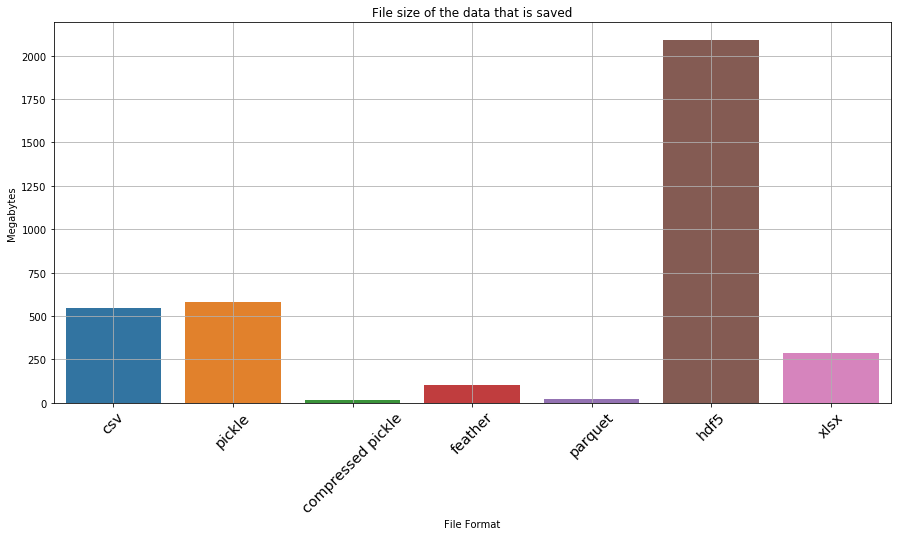

In [21]:
plt.figure(figsize=(15,7))
ax = sns.barplot(x='type', y='file size (MB)', data=df_file_size_test)
_ = ax.set_xlabel('File Format')
_ = ax.set_ylabel('Megabytes')
_ = ax.set_title('File size of the data that is saved')
ax.grid(True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize='x-large')

[Text(0, 0, 'pickle - write'),
 Text(0, 0, 'pickle - read'),
 Text(0, 0, 'compressed pickle - write'),
 Text(0, 0, 'compressed pickle - read'),
 Text(0, 0, 'csv - write'),
 Text(0, 0, 'csv - read'),
 Text(0, 0, 'parquet - write'),
 Text(0, 0, 'parquet - read'),
 Text(0, 0, 'feather - write'),
 Text(0, 0, 'feather - read'),
 Text(0, 0, 'hdf5 - write'),
 Text(0, 0, 'hdf5 - read'),
 Text(0, 0, 'xlsx - write'),
 Text(0, 0, 'xlsx - read')]

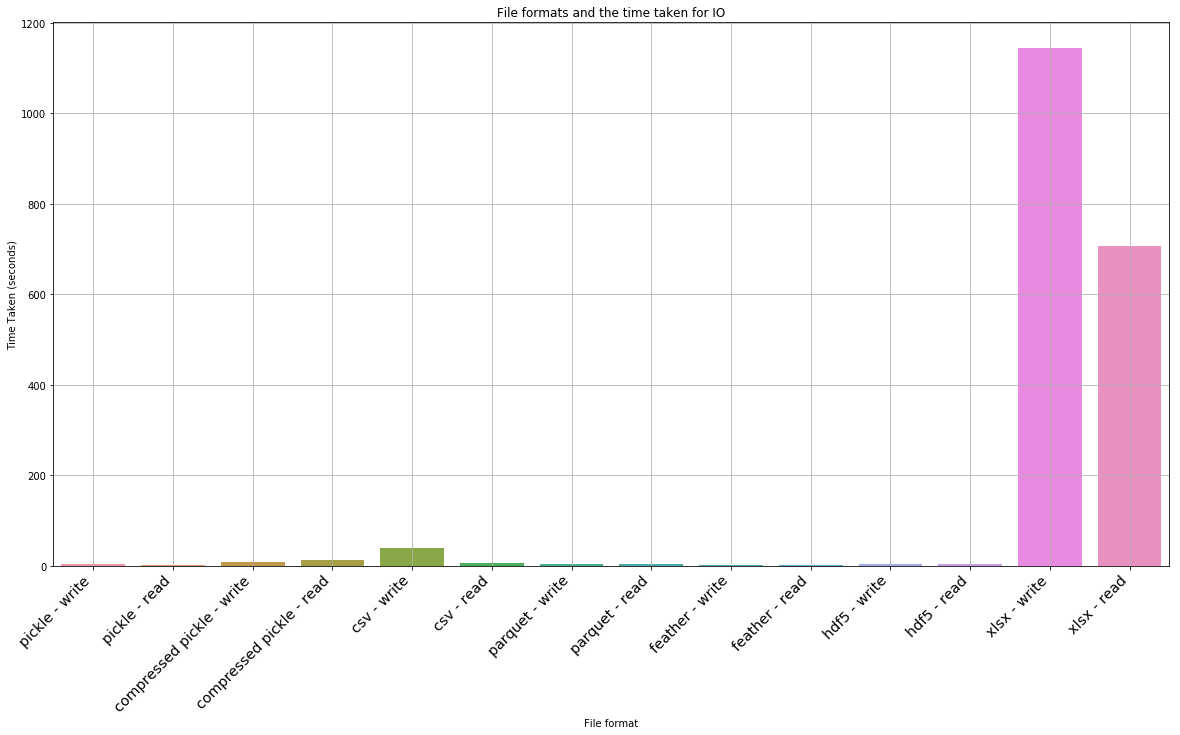

In [20]:
plt.figure(figsize=(20,10))
ax = sns.barplot(x='task', y='time taken', data=df_processing_test)
_ = ax.set_xlabel('File format')
_ = ax.set_ylabel('Time Taken (seconds)')
_ = ax.set_title('File formats and the time taken for IO')
ax.grid(True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize='x-large', horizontalalignment='right')

Okay... so `hdf5` and `xlsx` are clearly not favourable. If we drop them, what does the result look like

[Text(0, 0, 'csv'),
 Text(0, 0, 'pickle'),
 Text(0, 0, 'compressed pickle'),
 Text(0, 0, 'feather'),
 Text(0, 0, 'parquet')]

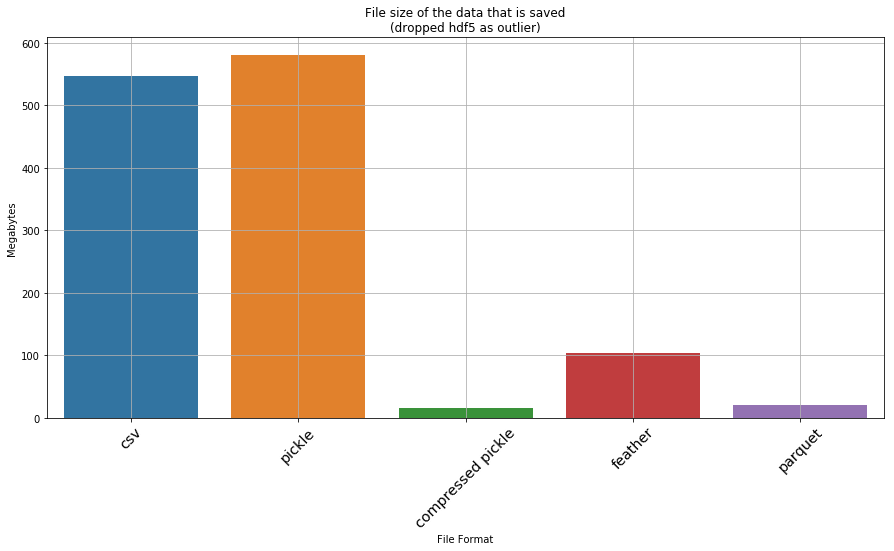

In [24]:
df_file_size_test_without_outliers = df_file_size_test.drop([5,6])
plt.figure(figsize=(15,7))
ax = sns.barplot(x='type', y='file size (MB)', data=df_file_size_test_without_outliers)
_ = ax.set_xlabel('File Format')
_ = ax.set_ylabel('Megabytes')
_ = ax.set_title('File size of the data that is saved\n(dropped hdf5 as outlier)')
ax.grid(True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize='x-large')

[Text(0, 0, 'pickle - write'),
 Text(0, 0, 'pickle - read'),
 Text(0, 0, 'compressed pickle - write'),
 Text(0, 0, 'compressed pickle - read'),
 Text(0, 0, 'csv - write'),
 Text(0, 0, 'csv - read'),
 Text(0, 0, 'parquet - write'),
 Text(0, 0, 'parquet - read'),
 Text(0, 0, 'feather - write'),
 Text(0, 0, 'feather - read')]

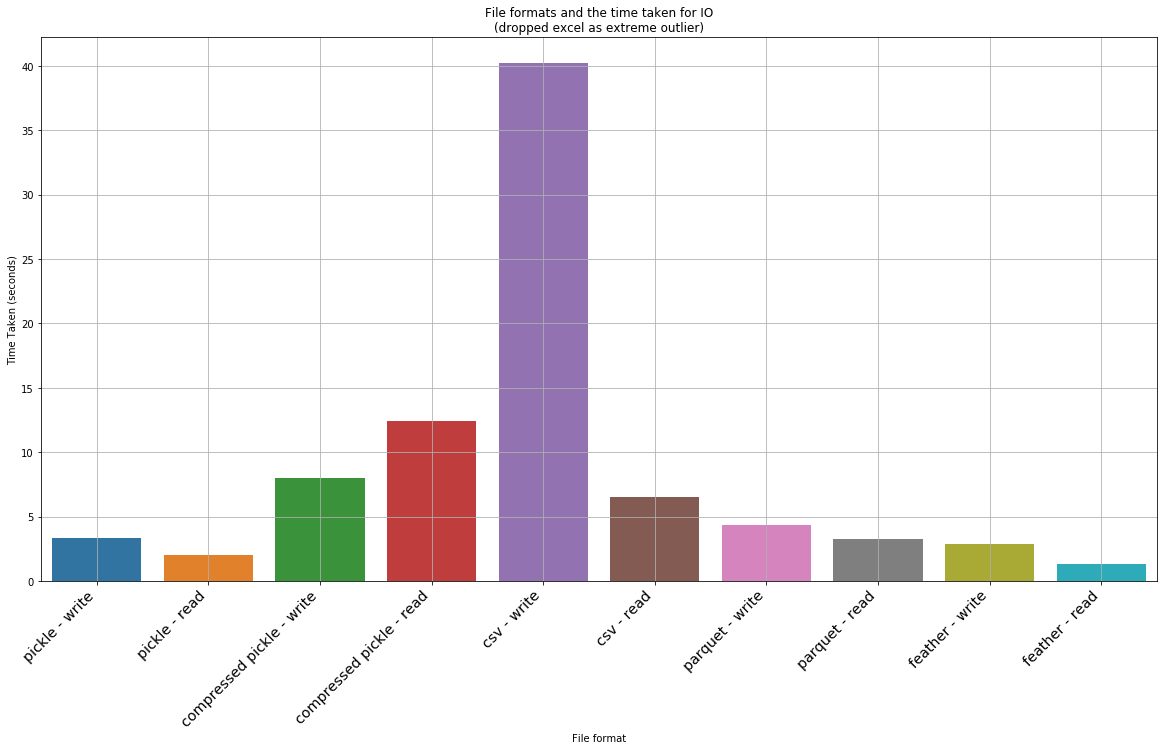

In [27]:
df_processing_test_without_outliers = df_processing_test.drop([10,11,12,13])
plt.figure(figsize=(20,10))
ax = sns.barplot(x='task', y='time taken', data=df_processing_test_without_outliers)
_ = ax.set_xlabel('File format')
_ = ax.set_ylabel('Time Taken (seconds)')
_ = ax.set_title('File formats and the time taken for IO\n(dropped excel as extreme outlier)')
ax.grid(True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize='x-large', horizontalalignment='right')

## Detailed results

We can print out the dataframes of interst to see the detailed data for all the files, including the outliers

In [25]:
df_file_size_test

,type,file size (MB)
0,csv,547.119179
1,pickle,579.979185
2,compressed pickle,14.979172
3,feather,104.476992
4,parquet,20.218006
5,hdf5,2088.185272
6,xlsx,288.665235


In [26]:
df_processing_test

,task,time taken
0,pickle - write,3.344310
1,pickle - read,1.997607
2,compressed pickle - write,7.953267
3,compressed pickle - read,12.442646
4,csv - write,40.201943
5,csv - read,6.481310
6,parquet - write,4.330219
7,parquet - read,3.246392
8,feather - write,2.894822
9,feather - read,1.323537


# Conclusion

A few observations from the above test:
* **The worst thing that can be used is `xlsx`, `csv` and `hdf5`**! CSV and Excel formats takes an insanely long time to read and write. HSF5 is quick to load, but is a whooping 2GB on disk! 
* A compressed pickle seems the ideal for space constrained IO -- is the second slowest to load and save (although not by a large margin), but only takes up 15mb;
* **Feather is the ideal one for a tradeoff of both on disk space and IO**. It is the fastest when it comes to IO (2.44x faster to read than second best which is parquet, and 1.5x faster to write than parquet), but takes up 100mb on disk, which isn't small.
* If space/size is a bit more of a consideration but speed is more important, then the best is parquet. However the ballance between IO speed and size makes it best compared to a compressed pickle. Parquet is a bit larger in size (20mb instead of 14mb) but it is much faster.

We can summarize some main tradeoffs that you could make:

| type | parquet compared to compressed pickle | Feather compared to parquet | Parquet compared to excel | Parquet compared to csv |
|:---:|:---:|:---:|:---:|:---:|
|  write/save | 1.8 faster  | 1.5x faster | 264x faster | 9.3x faster |
|  read/load |  2.8x faster | 2.46x faster | 217x faster | 2x faster |
|  file size |  1.3x larger | 5.2x larger | 14.3x smaller | 27x smaller |

As noted above, pickle is a python format -- meaning that the tradeoff partly depends on the language you use (R for ex?). However with R Markdown and [other solutions](https://stackoverflow.com/questions/35121192/reading-a-pickle-file-pandas-python-data-frame-in-r), this may not be a real limitation. 